Cihaz: cuda
Epoch [10/600], Loss: 0.0124
Epoch [20/600], Loss: 0.0067
Epoch [30/600], Loss: 0.0025
Epoch [40/600], Loss: 0.0037
Epoch [50/600], Loss: 0.0048
Epoch [60/600], Loss: 0.0082
Epoch [70/600], Loss: 0.0013
Epoch [80/600], Loss: 0.0027
Epoch [90/600], Loss: 0.0022
Epoch [100/600], Loss: 0.0035
Epoch [110/600], Loss: 0.0492
Epoch [120/600], Loss: 0.0010
Epoch [130/600], Loss: 0.0015
Epoch [140/600], Loss: 0.0001
Epoch [150/600], Loss: 0.0006
Epoch [160/600], Loss: 0.0002
Epoch [170/600], Loss: 0.0026
Epoch [180/600], Loss: 0.0008
Epoch [190/600], Loss: 0.0026
Epoch [200/600], Loss: 0.0025
Epoch [210/600], Loss: 0.0009
Epoch [220/600], Loss: 0.0025
Epoch [230/600], Loss: 0.0025
Epoch [240/600], Loss: 0.0130
Epoch [250/600], Loss: 0.0019
Epoch [260/600], Loss: 0.0007
Epoch [270/600], Loss: 0.0024
Epoch [280/600], Loss: 0.0041
Epoch [290/600], Loss: 0.0003
Epoch [300/600], Loss: 0.0008
Epoch [310/600], Loss: 0.0004
Epoch [320/600], Loss: 0.0074
Epoch [330/600], Loss: 0.0062
Epoch [

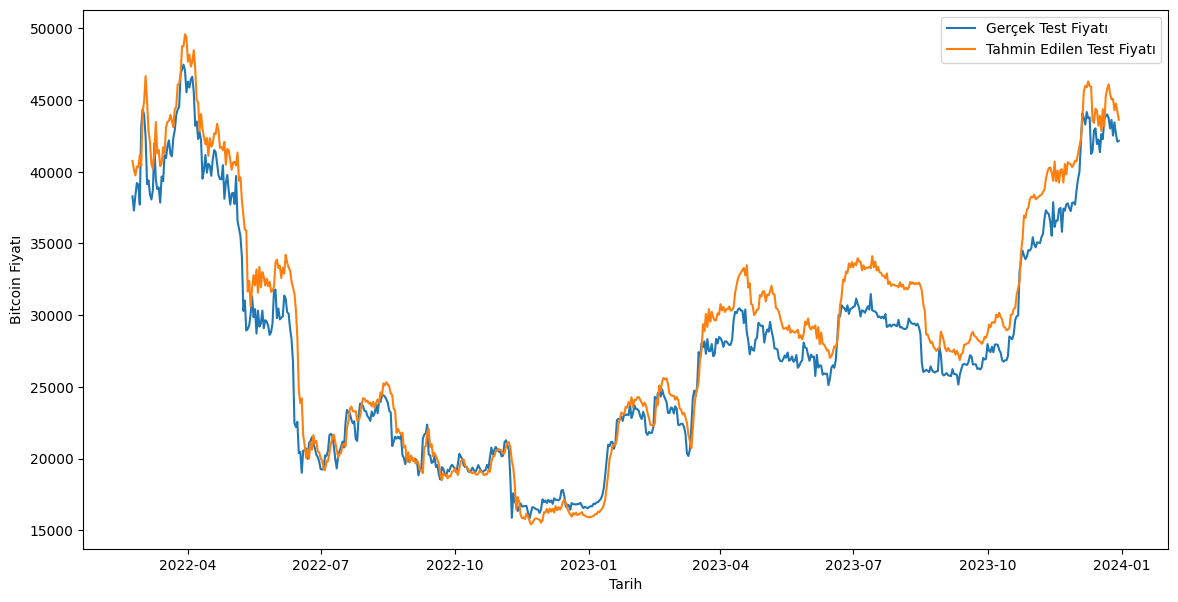

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from torchtsmixer import TSMixer


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Cihaz:", device)
data = pd.read_csv("bitcoin_price.csv")
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
close_data = data[['Close']].values

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(close_data)

def create_sequences(data, seq_length):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i + seq_length])
        labels.append(data[i + seq_length])
    return np.array(sequences), np.array(labels)

seq_length = 10
X, y = create_sequences(scaled_data, seq_length)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test, dtype=torch.float32).to(device)

train_data = TensorDataset(X_train, y_train)
test_data = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

input_dim = X_train.shape[2]
seq_len = X_train.shape[1]
model = TSMixer(sequence_length=seq_len, input_channels=input_dim, output_channels=1, prediction_length=1).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


num_epochs = 600
for epoch in range(num_epochs):
    model.train()
    for inputs, targets in train_loader:
        outputs = model(inputs)
        outputs = outputs.squeeze(-1)  # Çıkış tensorunun boyutunu hedefle uyumlu hale getiriyoruz
        loss = criterion(outputs, targets)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    if (epoch+1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

# Tahmin Yapma
model.eval()
train_predictions = []
test_predictions = []

with torch.no_grad():
    for inputs, _ in train_loader:
        outputs = model(inputs)
        train_predictions.extend(outputs.cpu().numpy())

    for inputs, _ in test_loader:
        outputs = model(inputs)
        test_predictions.extend(outputs.cpu().numpy())

# Tahminleri ve Gerçek Değerleri Ters Ölçekleme
train_predictions = scaler.inverse_transform(np.array(train_predictions).reshape(-1, 1))
y_train = scaler.inverse_transform(y_train.cpu().numpy().reshape(-1, 1))
test_predictions = scaler.inverse_transform(np.array(test_predictions).reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.cpu().numpy().reshape(-1, 1))


mae = mean_absolute_error(y_test, test_predictions)
mse = mean_squared_error(y_test, test_predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, test_predictions)

print(f"MAE (Mean Absolute Error): {mae:.4f}")
print(f"MSE (Mean Squared Error): {mse:.4f}")
print(f"RMSE (Root Mean Squared Error): {rmse:.4f}")
print(f"R^2 Score: {r2:.4f}")


plt.figure(figsize=(14, 7))
plt.plot(data.index[train_size+seq_length:], y_test, label="Gerçek Test Fiyatı")
plt.plot(data.index[train_size+seq_length:], test_predictions, label="Tahmin Edilen Test Fiyatı")
plt.xlabel("Tarih")
plt.ylabel("Bitcoin Fiyatı")
plt.legend()
plt.show()
